In [3]:
from utils.util import mkdir,seed_all
from omegaconf import OmegaConf
from cprint import *
from datasets.shape_net import ShapeNet
import torch
from models.Transform2D import Transform2D
from tqdm.notebook import tqdm
import numpy as np
%load_ext autoreload
%autoreload 2

In [4]:
seed_all(111)
config = OmegaConf.load("./configs/global_configs.yaml")
cprint.ok(config)
description = "Testing Overfit transforemer3" # Describe Experiment params here
logs_dir = "logs/all_dataset"
mkdir(logs_dir)

experiment_dir = f"{logs_dir}/{config['name']}"
mkdir(experiment_dir)
mkdir(f"{experiment_dir}/checkpoints")
mkdir(f"{experiment_dir}/tb")
mkdir(f"{experiment_dir}/visuals")

{'logs_dir': 'logs', 'is_train': True, 'name': 'testingOverfit', 'device': 'cuda:0', 'batch_size': 8, 'n_epochs': 500, 'print_every': 300, 'validate_every': 300, 'model': {'lr': 0.0001, 'criterion': 'BCE', 'pos_weight': 1.3, 'encoder': {'patch_size': 13, 'sequence_length': 100, 'embedding_dim': 768, 'patch_padding': 3}, 'transformer_encoder': {'d_model': 768, 'nhead': 12, 'num_layers': 12}, 'transformer_decoder': {'d_model': 768, 'nhead': 12, 'num_layers': 8, 'num_pos_embeddings': 64}}}
- logs/all_dataset directory found
- logs/all_dataset/testingOverfit directory found
- logs/all_dataset/testingOverfit/checkpoints directory found
- logs/all_dataset/testingOverfit/tb directory found
- logs/all_dataset/testingOverfit/visuals directory found


In [5]:
dataset = ShapeNet(cat="all",is_overfit=False) #Change overfit param here & cat here
# train_ds, valid_ds, test_ds = torch.utils.data.random_split(
#     dataset, [64, 0, 0])
train_ds = dataset

train_dataloader = torch.utils.data.DataLoader(
        train_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=16,   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=4,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )

validation_dataloader = torch.utils.data.DataLoader(
        train_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=4,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )

len(train_ds)


43783

In [6]:
model = Transform2D()
# Declare device
device = torch.device('cpu')
if torch.cuda.is_available() and config['device'].startswith('cuda'):
    device = torch.device(config['device'])
    cprint.ok('Using device:', config['device'])
else:
    cprint.warn('Using CPU')

model.to(device)


Using device: cuda:0


Transform2D(
  (patch_encoder): PatchEncoder(
    (pos_embedding): Embedding(100, 768)
    (patch_embed): PatchEmbed(
      (proj): Conv2d(4, 768, kernel_size=(13, 13), stride=(13, 13))
      (norm): Identity()
    )
  )
  (transformer_encoder): TransformerEncoder(
    (net): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): Transf

In [7]:
train_loss_running = 0.
best_loss_val = np.inf
model.train()

runningloss=0;
for epoch in tqdm(range(70)):
     for batch_idx, batch in tqdm(enumerate(train_dataloader)):
          ShapeNet.move_batch_to_device(batch, device)
          model.step(batch)
          loss = model.get_loss()  
          runningloss += loss["loss"]
          if(batch_idx %20 ==0):
            loss = model.get_loss()
            cprint.warn(f'Model Loss end of batch {batch_idx}: {loss["loss"]}')
            #cprint.warn(f'Model Demo Loss end of batch {batch_idx}: {loss["loss_demo"]}')
         #cprint.warn(f'Model Loss: {loss["loss_demo"]}')
     loss = model.get_loss()
     cprint.ok(f'Running Loss end of epoch {epoch}: {runningloss}')   
#      cprint.ok(f'Model Loss end of epoch {epoch}: {loss["loss"]}')
#      cprint.ok(f'Model Demo Loss end of epoch {epoch}: {loss["loss_demo"]}')
     runningloss=0
     model.scheduler.step()
#      if(epoch%10==0):
#          torch.save(model.state_dict(), f"{experiment_dir}/checkpoints/epoch-{epoch}.ckpt")

  0%|          | 0/70 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Model Loss end of batch 0: 0.8294427394866943
Model Loss end of batch 20: 0.4925037622451782
Model Loss end of batch 40: 0.381027489900589
Model Loss end of batch 60: 0.35424137115478516
Model Loss end of batch 80: 0.39149755239486694
Model Loss end of batch 100: 0.3078804612159729
Model Loss end of batch 120: 0.3874923288822174
Model Loss end of batch 140: 0.3652151823043823
Model Loss end of batch 160: 0.3390806019306183
Model Loss end of batch 180: 0.3675973415374756
Model Loss end of batch 200: 0.20725247263908386
Model Loss end of batch 220: 0.6718246936798096
Model Loss end of batch 240: 0.3547462821006775
Model Loss end of batch 260: 0.25616690516471863
Model Loss end of batch 280: 0.3696037828922272
Model Loss end of batch 300: 0.3539610207080841
Model Loss end of batch 320: 0.7379753589630127
Model Loss end of batch 340: 0.45155563950538635
Model Loss end of batch 360: 0.35715973377227783
Model Loss end of batch 380: 0.30028027296066284
Model Loss end of batch 400: 0.342815220

Running Loss end of epoch 0: 1046.738037109375


0it [00:00, ?it/s]

Model Loss end of batch 0: 0.3664973974227905
Model Loss end of batch 20: 0.4962030351161957
Model Loss end of batch 40: 0.42741858959198
Model Loss end of batch 60: 0.28273627161979675
Model Loss end of batch 80: 0.45786580443382263
Model Loss end of batch 100: 0.2718019485473633
Model Loss end of batch 120: 0.3734484314918518
Model Loss end of batch 140: 0.3055804669857025
Model Loss end of batch 160: 0.29980945587158203
Model Loss end of batch 180: 0.39144498109817505
Model Loss end of batch 200: 0.2812526822090149
Model Loss end of batch 220: 0.48421478271484375
Model Loss end of batch 240: 0.6616445779800415
Model Loss end of batch 260: 0.48776888847351074
Model Loss end of batch 280: 0.36006903648376465
Model Loss end of batch 300: 0.34083840250968933
Model Loss end of batch 320: 0.3194693922996521
Model Loss end of batch 340: 0.3468107283115387
Model Loss end of batch 360: 0.45324569940567017
Model Loss end of batch 380: 0.47662264108657837
Model Loss end of batch 400: 0.2807591

Running Loss end of epoch 1: 1028.63916015625


0it [00:00, ?it/s]

Model Loss end of batch 0: 0.3586563169956207
Model Loss end of batch 20: 0.2902850806713104
Model Loss end of batch 40: 0.3415076732635498
Model Loss end of batch 60: 0.5392053127288818
Model Loss end of batch 80: 0.3725860118865967
Model Loss end of batch 100: 0.38801923394203186
Model Loss end of batch 120: 0.4444429278373718
Model Loss end of batch 140: 0.3638705313205719
Model Loss end of batch 160: 0.54361891746521
Model Loss end of batch 180: 0.41215574741363525
Model Loss end of batch 200: 0.4024531841278076
Model Loss end of batch 220: 0.40993231534957886
Model Loss end of batch 240: 0.5018194913864136
Model Loss end of batch 260: 0.2549724578857422
Model Loss end of batch 280: 0.484999418258667
Model Loss end of batch 300: 0.26349005103111267
Model Loss end of batch 320: 0.3125271797180176
Model Loss end of batch 340: 0.39727556705474854
Model Loss end of batch 360: 0.4945871829986572
Model Loss end of batch 380: 0.29704439640045166
Model Loss end of batch 400: 0.456935405731

Running Loss end of epoch 2: 1027.5264892578125


0it [00:00, ?it/s]

Model Loss end of batch 0: 0.2943989634513855


KeyboardInterrupt: 

In [11]:
from utils.visualizations import visualize_occupancy,visualize_images
from utils.util import iou
sig = torch.nn.Sigmoid()
with torch.no_grad():
    z_prev = None
    for i in range(30):
        data = dataset[i]
        data['images'] = torch.tensor(data['images']).unsqueeze(0).float().cuda()
        data['voxels'] = torch.tensor(data['voxels']).float().cuda()
        #import pdb;pdb.set_trace()
        tgt = data['voxels']
        
        pred = model(data)
        
        #import pdb;pdb.set_trace()
        pred = pred.squeeze(0).clone()
        pred = sig(pred)
        #import pdb;pdb.set_trace()
        #pred
        #print(iou(tgt.unsqueeze(0),pred.unsqueeze(0),0.4))
        if(z_prev is not None):
            #import pdb;pdb.set_trace()
            #print("With Previous",iou(z_prev,pred.unsqueeze(0),0.4))
            print("With Target:",iou(tgt.unsqueeze(0),pred.unsqueeze(0),0.4))
        z_prev = pred.unsqueeze(0).clone()
#         pred[pred>=0.4] = 1
#         pred[pred<0.4] = 0
        torch.save(pred, f"{experiment_dir}/visuals/pred_{i}.pt")
        #print("With Target:",iou(tgt.unsqueeze(0),pred.unsqueeze(0),0.4))
        #visualize_occupancy(tgt.detach().squeeze(0).cpu().numpy(),flip_axes=True)
        cprint.ok("=============================================================")
        #visualize_occupancy(pred.detach().squeeze(0).cpu().numpy(),flip_axes=True)
        #plot_voxels(pred.detach(), rot02=1, rot12=1)
        #import pdb;pdb.set_trace()
    

With Target: tensor([0.2588], device='cuda:0')
With Target: tensor([0.2024], device='cuda:0')
With Target: tensor([0.2252], device='cuda:0')
With Target: tensor([0.1831], device='cuda:0')
With Target: tensor([0.1718], device='cuda:0')
With Target: tensor([0.2510], device='cuda:0')
With Target: tensor([0.1946], device='cuda:0')
With Target: tensor([0.2255], device='cuda:0')
With Target: tensor([0.1971], device='cuda:0')
With Target: tensor([0.2054], device='cuda:0')
With Target: tensor([0.2764], device='cuda:0')
With Target: tensor([0.2469], device='cuda:0')
With Target: tensor([0.2079], device='cuda:0')
With Target: tensor([0.2755], device='cuda:0')
With Target: tensor([0.0948], device='cuda:0')
With Target: tensor([0.1990], device='cuda:0')
With Target: tensor([0.2253], device='cuda:0')
With Target: tensor([0.2299], device='cuda:0')
With Target: tensor([0.2419], device='cuda:0')
With Target: tensor([0.2156], device='cuda:0')
With Target: tensor([0.1728], device='cuda:0')
With Target: 

In [12]:
import io
from matplotlib import pyplot as plt
from PIL import Image
def plot_voxels(voxels, rot01=0, rot02=0, rot12=0):
    voxels = voxels[0]
    voxels[voxels >= 0.5] = 1
    voxels[voxels < 0.5] = 0
    voxels = voxels.rot90(rot01, (0, 1))
    voxels = voxels.rot90(rot02, (0, 2))
    voxels = voxels.rot90(rot12, (1, 2))
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_box_aspect((1, 1, 1))
    ax.voxels(voxels)

    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)

    plt.clf()
    plt.close()

    return img

In [20]:
y4 = torch.load(f"{experiment_dir}/visuals/pred_20.pt")
y5 = torch.load(f"{experiment_dir}/visuals/pred_15.pt")

In [14]:
def compute_iou(pred, gt):
    pred = pred.clone()
    gt = gt.clone()
    gt[gt<=0.4] = 0
    gt[gt>=0.4] = 1
    pred[pred <= 0.4] = 0
    pred[pred >= 0.4] = 1
    print((pred!=gt).sum())
    intersection = torch.sum(pred.mul(gt)).float()
    union = torch.sum(torch.ge(pred.add(gt), 1)).float()
    return intersection / union

In [21]:
compute_iou(y4,y5)

tensor(5, device='cuda:0')


tensor(0.9973, device='cuda:0')

In [ ]:
torch.abs((y4-y5)).sum()

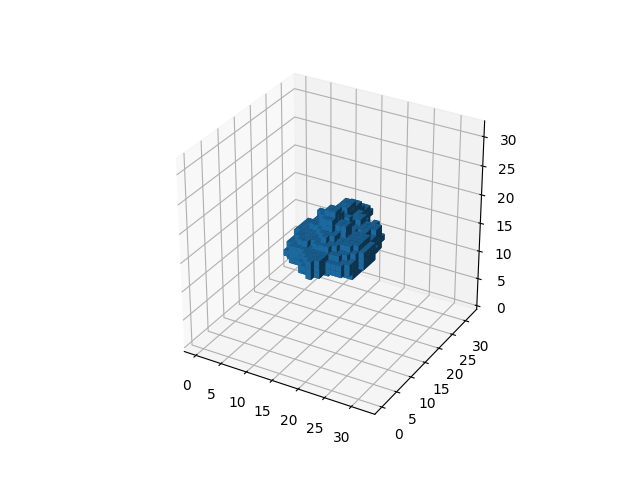

In [22]:
plot_voxels(y5.detach(), rot02=1, rot12=1)

In [ ]:
visualize_occupancy(y4.detach().squeeze(0).cpu().numpy(),flip_axes=True)

In [ ]:
import timm

In [ ]:
pip install timm